In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from astropy.table import Table
import os
import numpy as np
import cartopy.crs as ccrs
import json

In [2]:
os.chdir('/home/walml/repos/zoobot')

In [3]:
dr1_dr2 = Table.read('/media/walml/beta/decals/catalogs/decals_dr1_and_dr2.csv').to_pandas()

/home/walml/anaconda3/envs/zoobot/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: TableReplaceWarning: converted column 'background' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/walml/anaconda3/envs/zoobot/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: TableReplaceWarning: converted column 'bad_image' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/walml/anaconda3/envs/zoobot/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: TableReplaceWarning: converted column 'band' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/walml/anaconda3/envs/zoobot/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: TableReplaceWarning: converted column 'bands' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/walml/anaconda3/envs/zoobot/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: TableRe

In [4]:

# https://github.com/zooniverse/decals/blob/master/decals/a_download_decals/get_catalogs/selection_cuts.py#L28
def apply_selection_cuts(input_catalog, snap_tolerance=1e-3):
    """
    Select only galaxies with petrotheta > 3 and not within 1e-3 of bad measurement snap value
    Args:
        catalog (astropy.Table): Galaxy catalog including NSA information
        snap_tolerance (float): Minimum deviation from bad measurement snap value allowed
    Returns:
        (astropy.Table) catalog of galaxies matching selection criteria above
    """

    # Galaxies should be sufficiently extended across the sky
    petrotheta_above_3 = input_catalog['petrotheta'] > 3

    # NSA catalog’s petrotheta calculation sometimes fails to a ‘default’ value
    # Any galaxies with petrotheta within 1e-3 of the snap_to value likely has the wrong size.
    bad_petrotheta_value = 27.653702  # this 'magic' value can be confirmed by looking at petrotheta histograms
    snap_lower_limit = bad_petrotheta_value - snap_tolerance
    snap_upper_limit = bad_petrotheta_value + snap_tolerance

    above_snap_lower_limit = input_catalog['petrotheta'] > snap_lower_limit
    below_snap_upper_limit = input_catalog['petrotheta'] < snap_upper_limit
    within_snap_window = above_snap_lower_limit & below_snap_upper_limit

    selected_catalog = input_catalog[petrotheta_above_3 & ~ within_snap_window]
    return selected_catalog

In [5]:
to_upload = Table.read('/media/walml/beta/decals/catalogs/dr5_nsa1_0_0_to_upload.fits').to_pandas()  # same table, now with png_ready/fits_ready/fits_filled cols added
to_upload['iauname'] = to_upload['iauname'].str.decode('utf8')

In [6]:
not_in_dr1_dr2 = to_upload[~to_upload['iauname'].isin(dr1_dr2['iauname'])]
len(not_in_dr1_dr2)

247746

In [7]:
should_be_uploaded = not_in_dr1_dr2.query('fits_filled')
len(should_be_uploaded)

214288

### What did we upload so far?

In [9]:
latest_subjects = pd.read_csv('/home/walml/repos/gz-panoptes-reduction/data/latest_subjects_export.csv')
latest_subjects = latest_subjects[latest_subjects['workflow_id'].isin([6122.0, 10582.0, 10581.0])]  # decals public workflows
latest_subjects = latest_subjects[~latest_subjects['subject_set_id'].isin([77652])]  # remove eagle subjects
len(latest_subjects)

414660

In [11]:
latest_subjects['workflow_id'].value_counts()

6122.0     230381
10582.0    178513
10581.0      5766
Name: workflow_id, dtype: int64

In [12]:
latest_subjects['metadata'] = latest_subjects['metadata'].apply(json.loads)

In [13]:
def get_iauname(metadata):
    possible_keys = ['iauname', '!iauname', 'IAUNAME', '!IAUNAME']
    for key in possible_keys:
        if key in metadata.keys():
            return metadata[key]
    return np.nan

In [14]:
latest_subjects['iauname'] = latest_subjects['metadata'].apply(get_iauname)

In [15]:
missing = should_be_uploaded[~should_be_uploaded['iauname'].isin(latest_subjects['iauname'])]
len(missing)

29151

In [16]:
missing.sample(10)

,iauname,nsa_id,ra,dec,petrotheta,petroth50,petroth90,z,nsa_version,fits_loc,png_loc,fits_ready,fits_filled,png_ready
297868,J105056.96+043050.8,593203,162.737391,4.514150,41.520054,11.515634,36.387856,0.126411,b'1_0_0',b'/Volumes/alpha/decals/fits_native/dr5/J105/J...,b'/Volumes/alpha/decals/png_native/dr5/J105/J1...,True,True,True
340057,J171109.45+210405.2,687777,257.789343,21.068017,14.849023,5.415851,16.622961,0.032222,b'1_0_0',b'/Volumes/alpha/decals/fits_native/dr5/J171/J...,b'/Volumes/alpha/decals/png_native/dr5/J171/J1...,True,True,True
55050,J211721.80-060533.6,103333,319.340857,-6.092663,4.910090,2.426346,5.648035,0.125550,b'1_0_0',b'/Volumes/alpha/decals/fits_native/dr5/J211/J...,b'/Volumes/alpha/decals/png_native/dr5/J211/J2...,True,True,True
281497,J144824.32+183109.4,565849,222.101385,18.519270,10.818974,3.951527,12.061677,0.038381,b'1_0_0',b'/Volumes/alpha/decals/fits_native/dr5/J144/J...,b'/Volumes/alpha/decals/png_native/dr5/J144/J1...,True,True,True
50641,J140614.34+034650.1,86300,211.559780,3.780596,5.558836,2.351681,7.670071,0.094000,b'1_0_0',b'/Volumes/alpha/decals/fits_native/dr5/J140/J...,b'/Volumes/alpha/decals/png_native/dr5/J140/J1...,True,True,True
153268,J083222.02+081853.7,365785,128.091982,8.314594,5.055066,2.518692,5.300970,0.074141,b'1_0_0',b'/Volumes/alpha/decals/fits_native/dr5/J083/J...,b'/Volumes/alpha/decals/png_native/dr5/J083/J0...,True,True,True
302882,J232212.77+165759.5,605883,350.554082,16.967157,5.355898,2.777563,4.309978,0.146948,b'1_0_0',b'/Volumes/alpha/decals/fits_native/dr5/J232/J...,b'/Volumes/alpha/decals/png_native/dr5/J232/J2...,True,True,True
170247,J141757.30+052721.2,388955,214.488769,5.455891,6.311381,2.777563,6.623578,0.054959,b'1_0_0',b'/Volumes/alpha/decals/fits_native/dr5/J141/J...,b'/Volumes/alpha/decals/png_native/dr5/J141/J1...,True,True,True
236915,J104902.74+183350.6,512028,162.261464,18.564052,5.648035,2.633897,6.496888,0.021206,b'1_0_0',b'/Volumes/alpha/decals/fits_native/dr5/J104/J...,b'/Volumes/alpha/decals/png_native/dr5/J104/J1...,True,True,True
196359,J143835.74+300831.7,455626,219.648944,30.142162,4.268561,2.078999,4.545066,0.070770,b'1_0_0',b'/Volumes/alpha/decals/fits_native/dr5/J143/J...,b'/Volumes/alpha/decals/png_native/dr5/J143/J1...,True,True,True


In [26]:
missing['file_loc'] = missing['png_loc'].str.decode('utf8')
missing['file_loc'] = missing['file_loc'].str.replace('/Volumes/alpha', '/media/walml/beta') 

/home/walml/anaconda3/envs/zoobot/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/walml/anaconda3/envs/zoobot/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [28]:
from PIL import Image

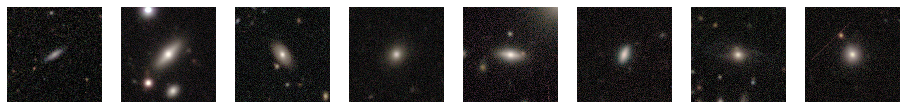

In [34]:
n_galaxies = 8
fig, axes = plt.subplots(ncols=n_galaxies, figsize=(16, 16))
for ax in axes:
    galaxy = missing.sample().squeeze()
    ax.imshow(np.array(Image.open(galaxy['file_loc'])))
    ax.axis('off')

In [35]:
missing.to_csv('final_random_decals_dr5_galaxies_to_upload.csv', index=False)